->Explore the example data of Dogs vs. Cats

->Build and train a neural network to classify between the two pets

->Evaluate the training and validation accuracy

->Transfer learning- using prebuilt convolution layers of one model

In [8]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

import zipfile

local_zip='./cats_and_dogs_filtered.zip'
zip_ref=zipfile.ZipFile(local_zip,'r').extractall()


--2023-05-18 09:08:15--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 142.251.172.128, 142.251.171.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   100MB/s    in 0.7s    

2023-05-18 09:08:16 (100 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [9]:
import os
base_dir='cats_and_dogs_filtered'

train_dir=os.path.join(base_dir,'train')
validation_dir=os.path.join(base_dir,'validation')

train_cats_dir=os.path.join(train_dir,'cats')
train_dogs_dir=os.path.join(train_dir,'dogs')

validation_cats_dir=os.path.join(validation_dir,'cats')
validation_dogs_dir=os.path.join(validation_dir,'dogs')

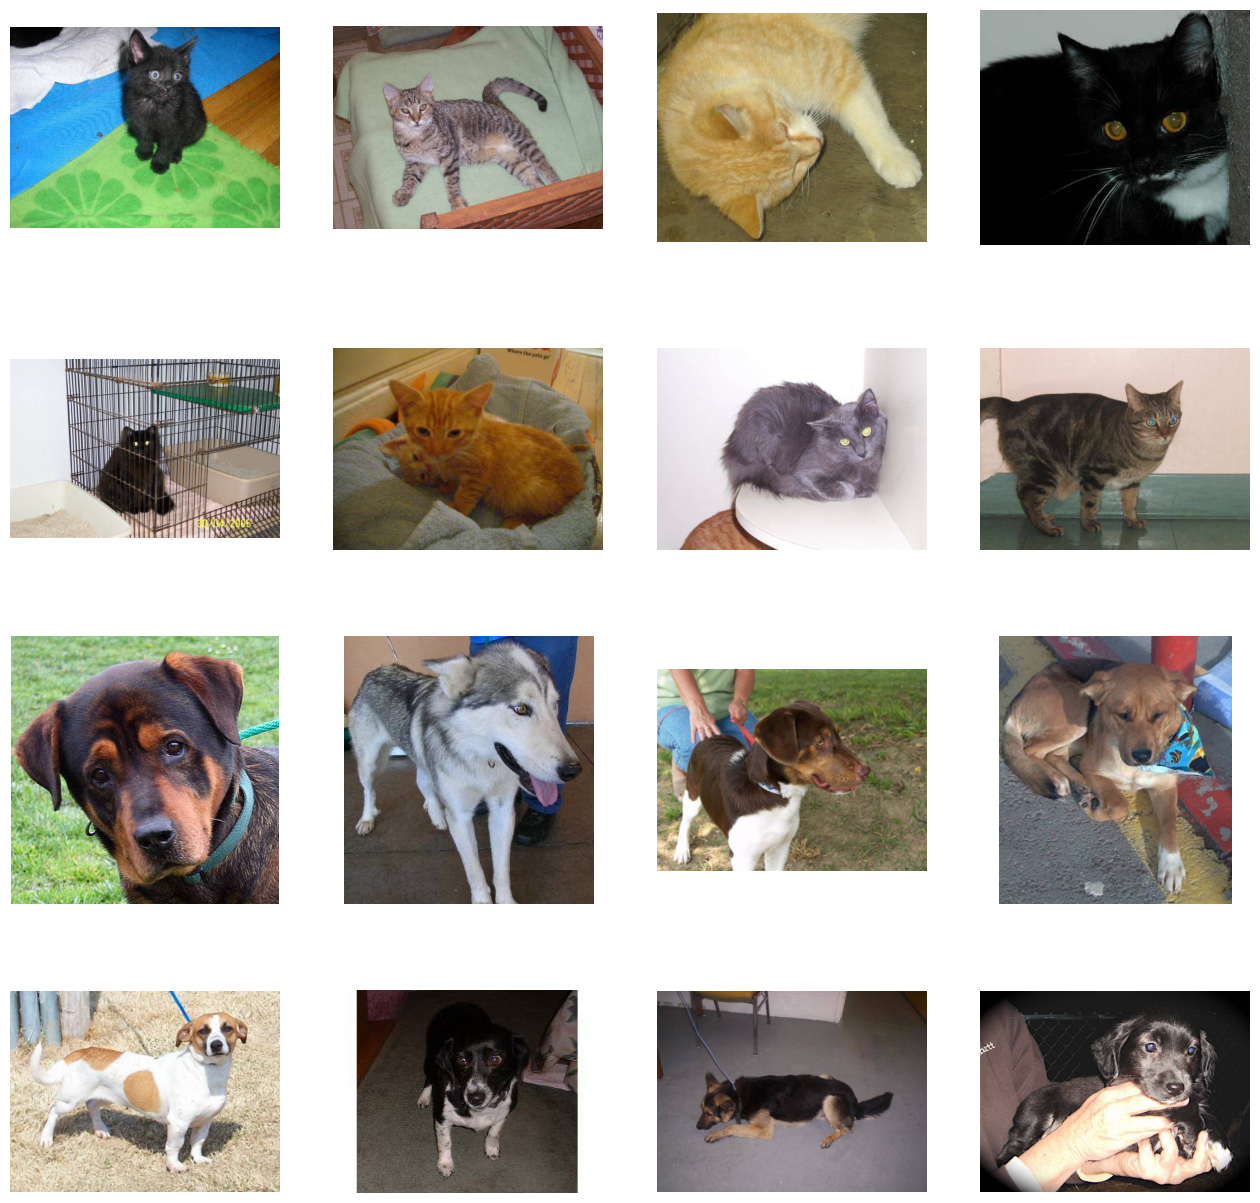

In [10]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows=4
ncols=4

pic_index=0

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [11]:
# import tensorflow as tf

# model=tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512,activation='relu'),
#     tf.keras.layers.Dense(1,activation='sigmoid'),  
# ])
# model.summary()

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model= InceptionV3(input_shape=(150,150,3),
                               include_top=False,
                               weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable=False

# pre_trained_model.summary()

last_layer=pre_trained_model.get_layer('mixed7')
print('Last layer output shape: ',last_layer.output_shape)
last_output=last_layer.output

--2023-05-18 09:08:19--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 142.251.172.128, 142.251.171.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   207MB/s    in 0.4s    

2023-05-18 09:08:19 (207 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Last layer output shape:  (None, 7, 7, 768)


In [12]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

x=layers.Flatten()(last_output)

x=layers.Dense(1024,activation='relu')(x)

x=layers.Dropout(0.2)(x)

x=layers.Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input, x) 

In [13]:
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( 
    rescale = 1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen  = ImageDataGenerator( 
    rescale = 1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

Epoch 1/20
100/100 - 40s - loss: 0.3519 - accuracy: 0.8705 - val_loss: 0.3889 - val_accuracy: 0.8400 - 40s/epoch - 400ms/step
Epoch 2/20
100/100 - 25s - loss: 0.2014 - accuracy: 0.9160 - val_loss: 0.3122 - val_accuracy: 0.8660 - 25s/epoch - 252ms/step
Epoch 3/20
100/100 - 23s - loss: 0.1800 - accuracy: 0.9285 - val_loss: 0.1698 - val_accuracy: 0.9310 - 23s/epoch - 228ms/step
Epoch 4/20
100/100 - 23s - loss: 0.1768 - accuracy: 0.9285 - val_loss: 0.1596 - val_accuracy: 0.9310 - 23s/epoch - 228ms/step
Epoch 5/20
100/100 - 23s - loss: 0.1584 - accuracy: 0.9420 - val_loss: 0.1731 - val_accuracy: 0.9300 - 23s/epoch - 228ms/step
Epoch 6/20
100/100 - 23s - loss: 0.1705 - accuracy: 0.9290 - val_loss: 0.1775 - val_accuracy: 0.9350 - 23s/epoch - 229ms/step
Epoch 7/20
100/100 - 23s - loss: 0.1459 - accuracy: 0.9440 - val_loss: 0.1860 - val_accuracy: 0.9330 - 23s/epoch - 228ms/step
Epoch 8/20
100/100 - 23s - loss: 0.1451 - accuracy: 0.9410 - val_loss: 0.1909 - val_accuracy: 0.9250 - 23s/epoch - 226

In [16]:
import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))
  
  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")
 

Saving dog2.jpeg to dog2.jpeg
Saving dog1.jpg to dog1.jpg
Saving cat2.jpg to cat2.jpg
Saving cat1.jpg to cat1.jpg
1/1 [==============================] - 1s 1s/step
[0.9999988]
dog2.jpeg is a dog
1/1 [==============================] - 0s 29ms/step
[1.]
dog1.jpg is a dog
1/1 [==============================] - 0s 26ms/step
[7.909067e-06]
cat2.jpg is a cat
1/1 [==============================] - 0s 24ms/step
[0.03571862]
cat1.jpg is a cat
